# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
CONFIG_FILE='config.yaml'


#clone report for colab
import yaml,os,sys,datetime,time

#setup directories
if os.name=='nt':
    pass
else:               #colab setup below
    if not os.path.exists('./repo') :
        !git clone $repo repo
        sys.path.append("repo/lib")
        sys.path.append('repo')       
    
    # to update APT if not updated
    path='/var/lib/apt/lists'
    if (datetime.datetime.now()-
        datetime.datetime.strptime(time.ctime(os.path.getmtime(path)), "%c")).days:
      !apt update
    
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    
sys.path.append('lib')
# sys.path.append(LIB)

import utils
cfg=utils.setup_env(CONFIG_FILE)  #auth_file defaulted from {AUTH}/auth/yaml

for x in cfg['env'][os.name]: 
    # os.environ[x]=cfg['env'][os.name][x]
    globals()[x]=cfg['env'][os.name][x]

#need to use following for each sheet
service_account_file=f'{os.environ["AUTH"]}/{cfg["AUTH"]["service_accounts"]["indiathon"]}'

## Code

In [2]:
import yaml
import importlib
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Linkedin=socialmediasite.Linkedin

# Process
## Create headless

In [3]:
" Test Selenium headless"
if True:#'b' in globals():
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    

In [4]:
# %debug
# if os.name=='nt':
nerodia.default_timeout=3
li=Linkedin(b,                               #authFile=f'{AUTH}/auth.yaml'
           )
utils.setLogger(f"{LOG}/strava-automation.log")


2022-10-21 14:03:46:INFO:Logger file: c:/m/logging/strava-automation.log


In [5]:
li.login("avinash")

display(li.browser.url)

li.scrolldown(29)

'https://www.linkedin.com/feed/'

In [6]:

import pandas as pd

nerodia.default_timeout=.5

def getPostData(postTag):
  "Return data regarding one post in linkedin feed"
  post={}
  if not postTag.exists:
    return
  _map={
      'post':'postTag.parent().element(class_name="visually-hidden").text',
      'urn':'postTag.attributes["data_urn"]',
      'name':'postTag.element(class_name="feed-shared-actor__name").text',
      'userUrl':'postTag.link(class_name="feed-shared-actor__container-link").href',
      'likes':'postTag.element(class_name="social-details-social-counts__reactions-count").text',
        # len('.div(class_name='feed-shared-social-actions').buttons(text='Like'))',
          # 'react-button--active' in 'react-button__text--like' in 
      'liked':'"react-button--active" in postTag.div(class_name="feed-shared-social-actions").button(text="Like").class_name',
      # print(name','.element(class_name='feed-shared-social-actions'
      #                                                            ).button(text='Like').class_name)
      'text':'postTag.element(class_name="feed-shared-update-v2__commentary").text',
      'desc':'postTag.element(class_name="feed-shared-actor__description").text',
      'subdesc':'postTag.element(class_name="feed-shared-actor__sub-description").text',
      # if post['subdesc'] not in ['Promoted']:
      'deg':'postTag.span(class_name="feed-shared-actor__supplementary-actor-info").text',
  }

  for _v,_e in _map.items():
    try:
        _m = re.search(r'.*(postTag\..*\))',_e)
        if _m:
            if eval(_m.group(1)+".exists"):
                post[_v]=eval(_e,{"postTag":postTag})
    except Exception as e:
        pass
        print(f"error {e!r} {_v} {_e}")
    
    if 'text' in post : post['text']=post['text'][:40]
    if 'userUrl' in post : post['userUrl']=post['userUrl'].split("?")[0]
    # post['liked']='react-button--active' in postTag.div(class_name='feed-shared-social-actions'
    #                                                          ).button(text='Like').class_name

  return post    

def getPostIds():
  "Get list of all feed posts"
  nerodia.default_timeout=.1
  posts=[]

  for x in b.elements(class_name='feed-shared-update-v2',
                      ):#data_id=re.compile("urn:li:activity:")):
    if re.match(r"^urn:li:activity:",x.data_urn):
        try:
            post=getPostData(x)
            post.update({'el':x})
            posts.append( post)
        except Exception as e:
          # Logs the error appropriately. 
            print(f">>{e!r}")

  return posts

"list posts"
posts = getPostIds() #li.


## A. Give likes in feed

In [7]:
for i,p in enumerate(posts):
    # print(p['subdesc'])
    try:
        if  ('subdesc' in p) and ('Promoted' in p['subdesc']) or ('desc' in p) and ('Promoted' in p['desc']): 
            posts[i]['status']='Ads'
        elif ('deg' not in p): 
            posts[i]['status']='noDeg'
        elif '• 1st' not in p['deg']: 
            posts[i]['status']='no1Deg'
        elif p['liked']: 
            posts[i]['status']='PrvLiked'
        else:
            p['text']=p['text'] if 'text' in p else ''
            _likeButton=p['el'].div(class_name='feed-shared-social-actions'
                                  ).button(text='Like')
            if _likeButton.exists:  
                logging.info(f"Liking {p['name']} {p['text'][:30]}")
                try:
                    _likeButton.execute_script("arguments[0].click();", _likeButton)
                    posts[i]['status']='Pass'
                except Exception as e:
                  # Logs the error appropriately.
                    posts[i]['status']='Error'
                    print(f">>{e!r}")
    except Exception as e:
        print(f"{e!r} {p}")
        raise Exception


2022-10-21 14:09:35:INFO:Liking Raj Chopra Are your legacy, on-premises E
2022-10-21 14:09:46:INFO:Liking Devraj Bardhan Week 2 #S4HANA2022
Last Friday
2022-10-21 14:09:46:INFO:Liking Atin Angirish 
2022-10-21 14:09:47:INFO:Liking Priyabrata Ray 
2022-10-21 14:09:48:INFO:Liking Jonathan Tyler Proud to be on the panel with 
2022-10-21 14:09:48:INFO:Liking Siju Chandy Just finished the course “Data
2022-10-21 14:09:49:INFO:Liking Saju James Fragomen Kochi is thrilled to 
2022-10-21 14:09:49:INFO:Liking Gaurav Mittal Talib Anwar #Kudos Without you
2022-10-21 14:09:49:INFO:Liking Dr. Ashutosh Dabli Experimentation on site has al
2022-10-21 14:09:50:INFO:Liking Kiran Bhujle It’s time we talk about Mental
2022-10-21 14:09:51:INFO:Liking Samir Sinha Great to be with Raman Bhalla 
2022-10-21 14:09:51:INFO:Liking Anuradha A Wireless technology is evolvin
2022-10-21 14:09:51:INFO:Liking Shilpa M We are proud to partner with t
2022-10-21 14:09:52:INFO:Liking Julia Elliott Incredible. Where the po

In [8]:
_df=pd.DataFrame(posts)
stats=_df.status.value_counts().to_dict()
display(stats)
_df#.query("status == 'Pass'")

{'Pass': 31, 'Ads': 27, 'noDeg': 23, 'no1Deg': 15, 'PrvLiked': 3}

,post,name,userUrl,liked,text,desc,subdesc,deg,el,status,likes
0,Feed post number 1,Kirthi Sangampalayam,https://www.linkedin.com/in/kirthi-sangampalay...,True,Very fortunate to travel again to Bengal,Executive Partner at IBM Consulting,5d •\n5 days ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,PrvLiked,NaN
1,Feed post number 2,OwnBackup,https://www.linkedin.com/company/ownbackup/,False,"""We just thought, ‘Okay, please let Arch","31,624 followers",Promoted,NaN,#<Div: located: True; {'class_name': 'feed-sha...,Ads,12
2,Feed post number 7,Dr. Subhash Rastogi,https://www.linkedin.com/in/drrastogi,True,EXPRESSING GRATITUDE FOR SUCCESSFUL PROF,"Educator, Author, Entrepreneur, Mentor-Trainer...",5d •\n5 days ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,PrvLiked,NaN
3,Feed post number 10,ThinScale Technology Ltd.,https://www.linkedin.com/company/thinscale-tec...,False,Attention CX leaders: There’s gold benea,"5,281 followers",Promoted,NaN,#<Div: located: True; {'class_name': 'feed-sha...,Ads,4
4,Feed post number 16,Raj Chopra,https://www.linkedin.com/in/raj-chopra-sfo,False,"Are your legacy, on-premises ERP systems",A veteran of large scale ERP Implementations |...,2d •\n2 days ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,Pass,8
...,...,...,...,...,...,...,...,...,...,...,...
94,Feed post number 114,OnePlus,https://www.linkedin.com/company/oneplus/,False,From celebrating those colorful moments,"388,004 followers",Promoted,NaN,#<Div: located: True; {'class_name': 'feed-sha...,Ads,452
95,Feed post number 115,Sanjay Choubey,https://www.linkedin.com/in/sanjaychoubey,False,It was truly a pleasure of sharing insig,Vice President & CIO / CDO (North America) at ...,1w • Edited •\n1 week ago,(He/Him) • 1st,#<Div: located: True; {'class_name': 'feed-sha...,Pass,108
96,Feed post number 116,NaN,NaN,False,𝗗𝗮𝘁𝗮 𝗦𝗰𝗶𝗲𝗻𝗰𝗲 𝗟𝗲𝗮𝗿𝗻𝗶𝗻𝗴 𝗴𝘂𝗶𝗱𝗲 𝟮𝟬𝟮𝟮 🔥\n\n\n💡Da,NaN,NaN,NaN,#<Div: located: True; {'class_name': 'feed-sha...,noDeg,531
97,Feed post number 117,Deloitte,https://www.linkedin.com/company/deloitte/,False,This autumn isn’t looking gloomy at all,"10,959,347 followers",3d •\n3 days ago,NaN,#<Div: located: True; {'class_name': 'feed-sha...,noDeg,"4,962"


In [9]:
"logout"
# li.logout()

'logout'

# test linkedin

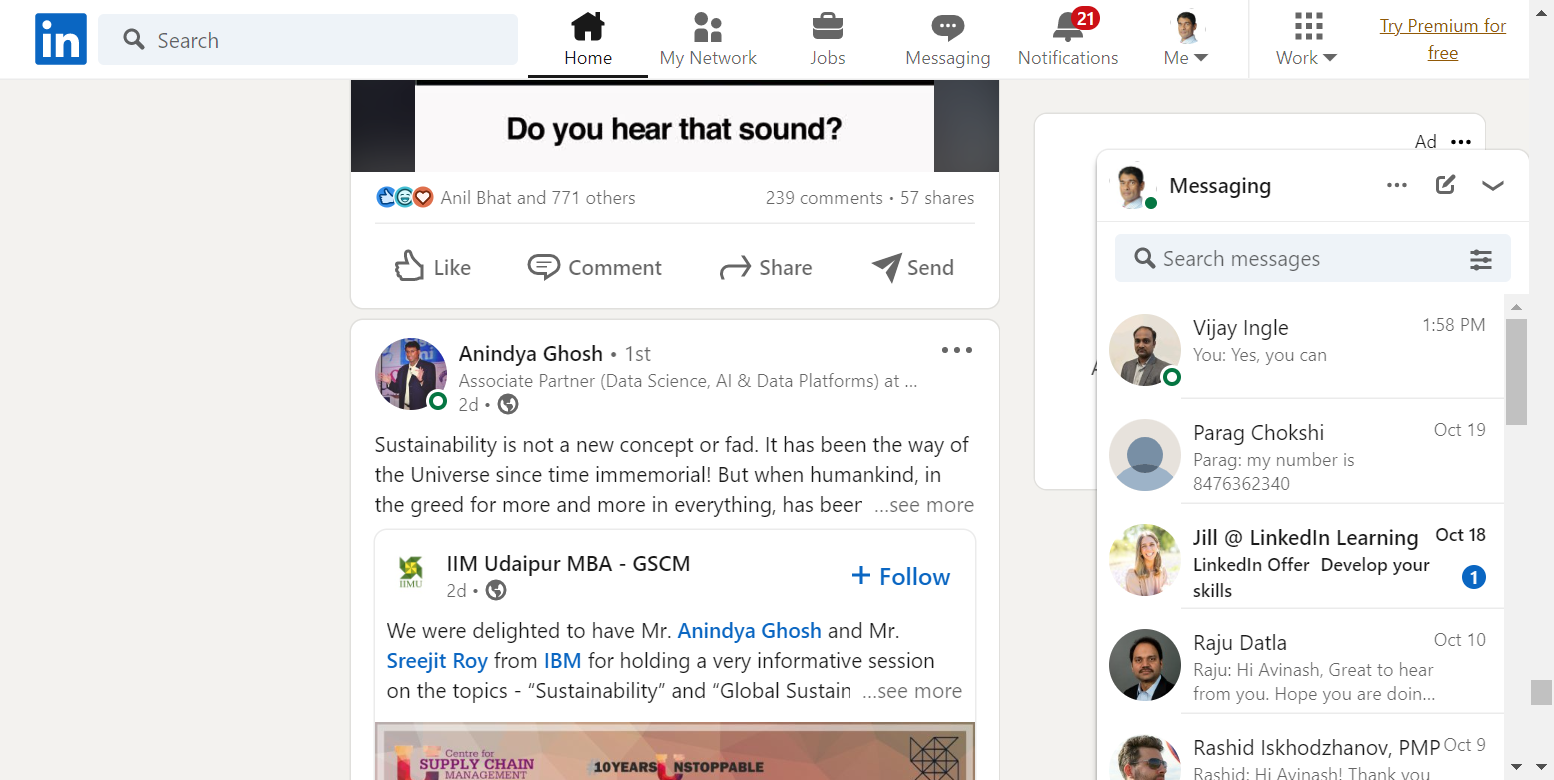

In [10]:

Image(b.screenshot.png())